<a href="https://colab.research.google.com/github/silvesray/Homework/blob/master/Copie_de_Lab_3_NLP_ENSAE_2021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab session 3 : From textual data modelling to text classification

## Lecture 3 recap: Task specific Modelling of Textual Data 
1. Preprocessing textual data (word segmentation, encoding)
2. Modelling: 
  a. Sequence Labelling (MEMMs, CRF)  
  b. Sequence Classification   
3. Evaluation 

## Lab objective

In this session, we will focus on Sequence Classification.
We will classify tweets according to their sentiment mainly using Scikit-learn as our machine learning toolkit. To do so you will have to:

## **1. Preprocessing**: preprocess the data
Adapt and combine the previous cleaning function (Lab session 2) with Scikit-learn Count Vectorizer or Tf-Idf Vectorizer for the text (X). 
Using the LabelBinarizer function for labels (Y).

## **2. Create sets**: training, dev, and test sets

## **3. Apply basic classifiers** for multiclass classification: Support Vector Machines, Random Forest.

## **4. Quantitative evaluation**: create a function that gives a quantitative evaluation for a prediction: 
- precision
- recall
- f1-score: macro and weighted
- accuracy
- roc curve for each label

## **5. Compare prediction scores** using previously trained embeddings (Lab session 2)

___
<h1><center><font color="blue">Preparation</font></center></h1>
### Download the corpora
(can also be manually downloaded here: https://gitlab.com/gguibon/ensae-ml4nlp-storage/-/tree/master)

### Tweets.csv = [Twitter US Airline Sentiment dataset](https://www.kaggle.com/crowdflower/twitter-airline-sentiment)

```
A sentiment analysis job about the problems of each major U.S. airline. Twitter data was scraped from February of 2015 and contributors were asked to first classify positive, negative, and neutral tweets, followed by categorizing negative reasons (such as "late flight" or "rude service").
```

### Political-media-DFE.csv = [Classification of Political Social Media dataset](https://data.world/crowdflower/classification-of-pol-social)

```
Contributors looked at thousands of social media messages from US Senators and other American politicians to classify their content. Messages were broken down into audience (national or the tweeter's constituency), bias (neutral/bipartisan, or biased/partisan), and finally tagged as the actual substance of the message itself (options ranged from informational, announcement of a media appearance, an attack on another candidate, etc.) Added: August 5, 2015 by CrowdFlower | Data Rows: 5000 
```

In [1]:
! wget https://gitlab.com/gguibon/ensae-ml4nlp-storage/-/raw/master/tweets.csv
! wget https://gitlab.com/gguibon/ensae-ml4nlp-storage/-/raw/master/Political-media-DFE.csv

--2021-09-08 15:38:11--  https://gitlab.com/gguibon/ensae-ml4nlp-storage/-/raw/master/tweets.csv
Resolving gitlab.com (gitlab.com)... 172.65.251.78, 2606:4700:90:0:f22e:fbec:5bed:a9b9
Connecting to gitlab.com (gitlab.com)|172.65.251.78|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3421431 (3.3M) [text/plain]
Saving to: ‘tweets.csv.5’

tweets.csv.5        100%[===================>]   3.26M  --.-KB/s    in 0.1s    

2021-09-08 15:38:11 (28.1 MB/s) - ‘tweets.csv.5’ saved [3421431/3421431]

--2021-09-08 15:38:11--  https://gitlab.com/gguibon/ensae-ml4nlp-storage/-/raw/master/Political-media-DFE.csv
Resolving gitlab.com (gitlab.com)... 172.65.251.78, 2606:4700:90:0:f22e:fbec:5bed:a9b9
Connecting to gitlab.com (gitlab.com)|172.65.251.78|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4309577 (4.1M) [text/plain]
Saving to: ‘Political-media-DFE.csv.5’

Political-media-DFE 100%[===================>]   4.11M  --.-KB/s    in 0.1s    

2021-09-

In [2]:
import pandas as pd
dfTweets = pd.read_csv('tweets.csv')
df_pol = pd.read_csv('Political-media-DFE.csv', encoding='latin-1')

In [3]:
dfTweets.iloc[0]

tweet_id                                         570306133677760513
airline_sentiment                                           neutral
airline_sentiment_confidence                                      1
negativereason                                                  NaN
negativereason_confidence                                       NaN
airline                                              Virgin America
airline_sentiment_gold                                          NaN
name                                                        cairdin
negativereason_gold                                             NaN
retweet_count                                                     0
text                            @VirginAmerica What @dhepburn said.
tweet_coord                                                     NaN
tweet_created                             2015-02-24 11:35:52 -0800
tweet_location                                                  NaN
user_timezone                            Eastern

**Re train** pol (*i.e.* political) embeddings using **Word2Vec skip gram** (copied and pasted from lab session 2 correction) for later use

In [4]:
# Usage of Phrases and Phraser from gensim
import nltk
from gensim.models.phrases import Phrases, Phraser
from nltk.tokenize import TreebankWordTokenizer, TweetTokenizer
nltk.download('punkt')
sent_detector = nltk.data.load('tokenizers/punkt/english.pickle')

def remove_hashtags(tokens):
  tokens = map(lambda x: x.replace('#', ''), tokens)
  return list(tokens)

def remove_url(tokens):
  tokens = filter(lambda x: "http" not in x, tokens)
  return list(tokens)

def remove_html(tokens):
  tokens = filter(lambda x: x[0]+x[-1] != '<>', tokens)
  return list(tokens)

from tqdm import tqdm
def tokenize_url_hashtags(corpus, tweets=False):
  if tweets:
    tokenizer = TweetTokenizer()
  else:
    tokenizer = TreebankWordTokenizer()  
    # Life hack : treebank word tokenizer won't keep html code in one token.
    # To preprocess economics news corpus, use tweettokenizer. 
  tokenized_sentences = []
  for sample in tqdm(corpus):
    # separating sentences
    for sentence in sent_detector.tokenize(sample):
      tokens = tokenizer.tokenize(sentence)
      tokens = remove_url(tokens)
      tokens = remove_html(tokens)
      tokens = remove_hashtags(tokens)
      tokens = list(map(lambda x: x.lower(), tokens))
      tokenized_sentences.append(tokens)
  return tokenized_sentences

cleaned_pol = tokenize_url_hashtags(df_pol.text.array, tweets=True)


from gensim.models.phrases import Phrases, Phraser

def clean_corpus(corpus, threshold=50, tweets=False):
  tokenized_sentences = tokenize_url_hashtags(corpus, tweets=tweets)
  phrases = Phrases(tokenized_sentences, threshold=threshold)

  # This lets you use it with less RAM and faster processing.
  # But it will no longer be possible to update the detector with new training 
  # samples
  phraser = Phraser(phrases)

  # Merging multi-word expressions in the tokenization
  clean_corpus = []
  for sentence in tokenized_sentences:
    clean_corpus.append(phraser[sentence])
  
  return clean_corpus

from gensim.models import Word2Vec
from multiprocessing import cpu_count

cpu = cpu_count()
print('The virtual instance has {} cpus, that will be used to train the word2vec model'.format(cpu))

# We will just get the "WordVectors" parameter from the trained Word2Vec model.
# Otherwise, we could continue training with some more exemples that could be
# fed on the fly to the model.
print("Training the political W2V ...")
pol = Word2Vec(cleaned_pol, size=100, window=5, min_count=3, workers=cpu)
pol.train(cleaned_pol, total_examples=len(cleaned_pol), epochs=10)
pol_wv = pol.wv

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


100%|██████████| 5000/5000 [00:01<00:00, 3948.75it/s]


The virtual instance has 2 cpus, that will be used to train the word2vec model
Training the political W2V ...


Explore the dataset.

Take a look at the columns:

In [5]:
dfTweets.columns

Index(['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence',
       'negativereason', 'negativereason_confidence', 'airline',
       'airline_sentiment_gold', 'name', 'negativereason_gold',
       'retweet_count', 'text', 'tweet_coord', 'tweet_created',
       'tweet_location', 'user_timezone'],
      dtype='object')

Take a look at the first tweet's `text` and `airline_sentiment` fields content.

Note: This tweets concern user sentiments related to different airline companies. Hence the column label!

(reminder: `iloc[0]` means *locate the element by index*, the index being 0 in this example)

In [6]:
print(dfTweets.text.iloc[0], dfTweets.airline_sentiment.iloc[0])

@VirginAmerica What @dhepburn said. neutral


Let's take a look at the dataframe first 5 elements:

In [7]:
dfTweets.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


Now let's see what it's shape is: `(number_of_rows, number_of_columns)`

In [8]:
dfTweets.shape

(14640, 15)

Here you can find some code for exploring the dataset using unsupervised learning (clustering) and visualization. A good clustering would require better tuned features.

If you want to dive into the scikit learn related documentation:
- [CountVectorizer doc](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)
- [preprocessing doc](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.preprocessing)

In [9]:
# JUST RUN AND LOOK: later you would like to solve the "Using pre trained embeddings section to complete this and rerun the clustering"

from sklearn.feature_extraction.text import CountVectorizer
from sklearn import preprocessing
import numpy as np

# def tokens2vectors(tokenCorpus):
#   ''' transforms our X into a list of list of vec (2D array) '''
#   # uncompleted for exercice purposes : solve the "Using pre trained embeddings" section after finishing this lab exercices to complete this and rerun the clustering"

# X = tokens2vectors(dfTweets.loc[:, "text"])

## For the moment, let's just use a CountVectorizer (token occurrence matrix)
X = dfTweets.loc[:, "text"]
cv = CountVectorizer() # max_features=300 reduces performances but is quite convenient for speed
X = cv.fit_transform(X)
print(X.shape)



(14640, 15051)


___
<h1><center><font color="blue">Explore Data Using Unsupervised Learning </font>(just to take a quick glance!)</center></h1>

Now let's train some KMeans clusetring with 3 target clusters (that we hope will represent positive, neutral and negative sentiments).

- [KMeans documentation](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)

In [10]:
# JUST RUN AND LOOK: later you would like to solve the "Using pre trained embeddings section to complete this and rerun the clustering"

from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, random_state=42, n_init=20, max_iter=300, verbose=0).fit(X)

In [11]:
# JUST RUN AND LOOK: later you would like to solve the "Using pre trained embeddings section to complete this and rerun the clustering"
# display some cluster related info
from collections import Counter
from sklearn.metrics.cluster import v_measure_score
from sklearn.cluster import KMeans

clusters = kmeans.predict(X)

print('Clusters:', clusters, 'of type', type(clusters))
print('Here is the occurrence counts for each cluster:')

for k, v in dict(Counter(clusters)).items():
  print('cluster', k, 'has', v, 'elements')

clusterTendancies = {'positive':list(), 'neutral': list(), 'negative': list()}

for sentiment, cluster in zip(dfTweets.loc[:, "airline_sentiment"], clusters):
  clusterTendancies[sentiment].append(cluster)

clusterTendancies = {k: Counter(v) for k, v in clusterTendancies.items()}
print('clusters distribution accross sentiments')
print(clusterTendancies)

print(dfTweets.loc[:,"text"].shape, 'hey', clusters.shape)

# Quantitative evaluation

label2id = {'positive':0, 'neutral':1, 'negative':2}
y_true = np.array([ label2id[sentiment] for sentiment in dfTweets.loc[:, "airline_sentiment"]])
print('v_measure score:', v_measure_score(y_true, clusters))

Clusters: [2 0 1 ... 1 2 0] of type <class 'numpy.ndarray'>
Here is the occurrence counts for each cluster:
cluster 2 has 5799 elements
cluster 0 has 4246 elements
cluster 1 has 4595 elements
clusters distribution accross sentiments
{'positive': Counter({2: 1168, 0: 722, 1: 473}), 'neutral': Counter({2: 1467, 1: 918, 0: 714}), 'negative': Counter({1: 3204, 2: 3164, 0: 2810})}
(14640,) hey (14640,)
v_measure score: 0.012332822846467587


We can see the clusters are not that good according to sentiment. The V-Measure score is very low (0-1 range)

This is not suprising considering this is unsupervised learning.

And see in which clusters the first two tweets are assigned:

In [12]:
# JUST RUN AND LOOK: later you would like to solve the "Using pre trained embeddings section to complete this and rerun the clustering"
print('cluster =', clusters[0], '| text =', dfTweets["text"][0], '| airline_sentiment =', dfTweets["airline_sentiment"][0])
print('cluster =', clusters[1], '| text =', dfTweets["text"][1], '| airline_sentiment =', dfTweets["airline_sentiment"][1])

cluster = 2 | text = @VirginAmerica What @dhepburn said. | airline_sentiment = neutral
cluster = 0 | text = @VirginAmerica plus you've added commercials to the experience... tacky. | airline_sentiment = positive


Let's do some **dimension reduction** using TSNE (alternatively you can use other methods: PCA, etc.).

Be aware: TSNE parameters highly affects the visualization which can then lead to opposite interpretations!

- [TSNE documentation](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html)

In [13]:
# JUST RUN AND LOOK: later you would like to solve the "Using pre trained embeddings section to complete this and rerun the clustering"
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, verbose=1, perplexity=30, learning_rate=100.0, early_exaggeration=2., n_iter=250)
X_tsne = tsne.fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 14640 samples in 0.001s...
[t-SNE] Computed neighbors for 14640 samples in 9.896s...
[t-SNE] Computed conditional probabilities for sample 1000 / 14640
[t-SNE] Computed conditional probabilities for sample 2000 / 14640
[t-SNE] Computed conditional probabilities for sample 3000 / 14640
[t-SNE] Computed conditional probabilities for sample 4000 / 14640
[t-SNE] Computed conditional probabilities for sample 5000 / 14640
[t-SNE] Computed conditional probabilities for sample 6000 / 14640
[t-SNE] Computed conditional probabilities for sample 7000 / 14640
[t-SNE] Computed conditional probabilities for sample 8000 / 14640
[t-SNE] Computed conditional probabilities for sample 9000 / 14640
[t-SNE] Computed conditional probabilities for sample 10000 / 14640
[t-SNE] Computed conditional probabilities for sample 11000 / 14640
[t-SNE] Computed conditional probabilities for sample 12000 / 14640
[t-SNE] Computed conditional probabilities for sam

Now we want to display a really pretty plot based on the reduced.

To do so we use the [Plotly library](https://plotly.com/):
- [plotly.express documentation](https://plotly.com/python/plotly-express/)
- [plotly.graph_objects documentation](https://plotly.com/python/graph-objects/)

In [14]:
# JUST RUN AND LOOK: later you would like to solve the "Using pre trained embeddings section to complete this and rerun the clustering"

import plotly.express as px
import plotly.graph_objects as go
import numpy as np


mapColors = {0:'lightseagreen', 1:'blueviolet', 2:'tomato'}
mapSentColors = {'positive':'lightseagreen', 'neutral':'blueviolet', 'negative':'tomato'}
colorsClusters = [mapColors[c] for c in clusters]
colorsSentiment = [mapSentColors[s] for s in dfTweets.airline_sentiment]

fig = go.Figure(data=go.Scatter(
    x = X_tsne[:, 0],
    y = X_tsne[:, 1],
    hovertext = list(zip(dfTweets.loc[:, "text"], dfTweets.loc[:,"airline_sentiment"])),
    mode='markers+text',
    marker=dict(
        size=4,
        color=colorsClusters, # colorsClusters or colorsSentiment
        colorscale='Viridis',
        showscale=True,
    )
))

fig.show()

Using word2vec embeddings results into another shape:

In [15]:
# JUST LOOK: later you would like to solve the "Using pre trained embeddings section to complete this and rerun the clustering"


The clustering does not necessarily map tweets by their sentiment. To obtain better scores, try different parameters later on. 

**Warning:** It takes a lot of time to recompute the whole Word2Vec + Kmeans + TSNE with better parameters! Do it later!

___
<h1><center><font color="blue">Sentiment Classification Test</font></center></h1>

We will now try to classify by sentiment in a supervised fashion.

Here you will things to do!




To start the sentiment classification mockup, you need to check you data.

In [16]:
# prepare data for a basic classification
X = dfTweets.loc[:, "text"]
print(X)
print(X.shape)

0                      @VirginAmerica What @dhepburn said.
1        @VirginAmerica plus you've added commercials t...
2        @VirginAmerica I didn't today... Must mean I n...
3        @VirginAmerica it's really aggressive to blast...
4        @VirginAmerica and it's a really big bad thing...
                               ...                        
14635    @AmericanAir thank you we got on a different f...
14636    @AmericanAir leaving over 20 minutes Late Flig...
14637    @AmericanAir Please bring American Airlines to...
14638    @AmericanAir you have my money, you change my ...
14639    @AmericanAir we have 8 ppl so we need 2 know h...
Name: text, Length: 14640, dtype: object
(14640,)


In [17]:
y = dfTweets.airline_sentiment
print(y)
print(y.shape)

0         neutral
1        positive
2         neutral
3        negative
4        negative
           ...   
14635    positive
14636    negative
14637     neutral
14638    negative
14639     neutral
Name: airline_sentiment, Length: 14640, dtype: object
(14640,)


## Step 1: Adapt the cleaning function tokenize_url_hashtags for this corpus

## 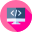 **TODO!** 
We take our previous cleaning function and utils and apply it on this dataset. But in order to do so you need to slightly adapt it (we do not need sentences but whole tweets as String)

In [18]:
from tqdm import tqdm
def tokenize_url_hashtags_4tweets(corpus):
  ''' modified version for our data structure (flattened and only for tweets proc)'''
  tokenizer = TweetTokenizer() 
  tokenized_sentences = []
  for sample in tqdm(corpus):
    tokens = tokenizer.tokenize(sample)
    tokens = remove_url(tokens)
    tokens = remove_html(tokens)
    tokens = remove_hashtags(tokens)
    tokens = list(map(lambda x: x.lower(), tokens))
    tokenized_sentences.append(tokens)
  tokenized_sentences = map(lambda r: " ".join(r), tokenized_sentences)
  return list(tokenized_sentences)

In [19]:
print(tokenize_url_hashtags_4tweets(X[:2]))

100%|██████████| 2/2 [00:00<00:00, 1462.19it/s]

['@virginamerica what @dhepburn said .', "@virginamerica plus you've added commercials to the experience ... tacky ."]


In [20]:
clean_data = tokenize_url_hashtags_4tweets(X)

len(clean_data), X.shape

100%|██████████| 14640/14640 [00:01<00:00, 9161.52it/s] 


(14640, (14640,))

## Step 2: Create Training set, Dev set and Test set


In a supervised classification task it is a good practice to split the dataset into 3 sets:
- Training set: **60%**: used to train the classifier and obtain a model
- Dev set: **20%**: used to apply the model and check performance while tuning it
- Test set: **20%** used as the final performance check to see if the generalization is ok

## 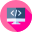 **TODO!**

Create these three sets!

Suggested convenient class: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

In [21]:
import numpy as np
from sklearn.model_selection import train_test_split

In [22]:
def split_data(data=list(), labels=list(), p=0.4, seed=5, ):
  dataset = {}
  if len(data) !=0 and len(labels)!= 0: 
    x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=p, random_state=seed)
    dataset = {"x_train": x_train, "x_test":x_test, "y_train": y_train, "y_test": y_test}
  
  elif len(data) == 0 and len(labels) !=0:
    y_train, y_test = train_test_split(labels, test_size=p, random_state=seed)
    dataset = { "y_train": y_train, "y_test": y_test}

  elif len(data) !=0  and len(labels) ==  0:
    x_train, x_test= train_test_split(data, test_size=p, random_state=seed)
    dataset = {"x_train": x_train, "x_test":x_test} 
  else:
    pass
  return dataset

## 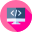 **TODO!**

Create train set (60% of the corpus)

In [23]:
# @TODO create train set 60% 
seed = 10
clean_data = tokenize_url_hashtags_4tweets(X)
dataset = split_data(data=clean_data)
x_train = dataset.get("x_train")

100%|██████████| 14640/14640 [00:01<00:00, 13975.30it/s]


In [24]:
len(x_train), len(clean_data), len(y)

(8784, 14640, 14640)

## 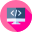 **TODO!**

Create dev and test sets (20% each, hence 50% from the remaining 40%)

In [25]:
# @TODO create dev 20% test 20% (hence 50% from the 40%)
dev_test = split_data(data=dataset.get("x_test"), p=0.5)
dev_data = dev_test.get("x_train")
test_data = dev_test.get("x_test")

## Preprocessing Text and Labels


We obtained our cleaned text in separate sets. Now we need to transform the text (the X sets) into vectors. Multiple approaches are available there. 
Start by using the CountVectorizer (bag of words and their occurrence counts in a sparse matrix).

https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html#sklearn.feature_extraction.text.CountVectorizer

Processing Text (X)

## 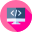 **TODO!**

Create occurrence count matrices using `CountVectorizer`.
- [CountVectorizer documentation](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html#sklearn.feature_extraction.text.CountVectorizer)

You will mostly need these two main methods:
```python
.fit() # train the countVectorizer
.transform() # methd from a trained instance to transform new text into occurrence matrix
```

In [26]:
from sklearn.feature_extraction.text import CountVectorizer
# @TODO for training set
count_vec = CountVectorizer()
train_data = count_vec.fit_transform(x_train)

In [27]:
train_data.shape

(8784, 10521)

## 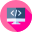 **TODO!**

Now apply this trained CountVectorizer on dev set (do not fit it again!)

In [28]:
# @TODO same goes for dev set
dev_set = count_vec.transform(dev_data)
test_set = count_vec.transform(test_data)

In [29]:
dev_set.shape, test_set.shape

((2928, 10521), (2928, 10521))

You need to do the same for labels. A binarization is the way to go as we want a matrix representing each label. 

https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelBinarizer.html

## 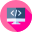 **TODO!**

Processing Labels (y)

It is recommended to use the [preprocessing.LabelBinarizer](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelBinarizer.html)

In [30]:
from sklearn import preprocessing
# @TODO binarize labels manually or using scikitlearn (recommended)

In [31]:
lb_encoder = preprocessing.LabelBinarizer()
lb_encoding = lb_encoder.fit_transform(y)

In [32]:
label_sets = split_data(labels=lb_encoding)
label_train = label_sets.get("y_train")
dev_test_label = split_data(labels=label_sets.get("y_test"), p=0.5)

dev_data_label = dev_test_label.get("y_train")
test_data_label = dev_test_label.get("y_test")

In [33]:
label_train.shape, dev_data_label.shape

((8784, 3), (2928, 3))

## Basic Support Vector Machine


Now that we extracted very basic features from our tweets (bag of word), we need to apply a simple classifier to predict for each tweet if it is positive neutral or negative. This is a multiclass classification. 

You will use **Support Vector Machine** (SVM) for this but in a multiclass fashion (SVM separate data between two labels but we have three labels). For this we can apply a SVM for each label trying to find if it belongs to the target label or something else: this is a **One Versus Rest** approach. Please use the two links below (linearSVC is faster, hence best suited for this exercice)

The classifier should be trained on train set and apply on dev set.

https://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsRestClassifier.html#sklearn.multiclass.OneVsRestClassifier

https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html#sklearn.svm.LinearSVC

Do not forget the main methods:

```python
.fit(X)
```

```python
.predict(y) # returns a list of predictions 
```



## 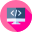 **TODO!**

Initialize and train the SVM classifier on the training set

In [34]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
# @TODO init and train classifier on training set

In [35]:
SEED = 10
lin_svc = LinearSVC(verbose=1, random_state=SEED)
one_vs_clf = OneVsRestClassifier(lin_svc, n_jobs=-1)
one_vs_clf.fit(train_data.toarray(), label_train)

OneVsRestClassifier(estimator=LinearSVC(C=1.0, class_weight=None, dual=True,
                                        fit_intercept=True, intercept_scaling=1,
                                        loss='squared_hinge', max_iter=1000,
                                        multi_class='ovr', penalty='l2',
                                        random_state=10, tol=0.0001,
                                        verbose=1),
                    n_jobs=-1)

## 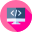 **TODO!**

Use the trained SVM to predict dev set labels and print the first 5 rows comparing ground truth and predictions

In [36]:
dev_set.shape

(2928, 10521)

In [37]:
# @TODO predict on dev set using trained classifier
y_pred_vs_clf = one_vs_clf.predict(dev_set)
print(y_pred_vs_clf.shape)
y_score_vs_clf = one_vs_clf.decision_function(dev_set)

(2928, 3)


In [38]:
# @TODO print the first 5 rows for verified labels and predicted ones
print(dev_data_label[:5])
print(y_pred_vs_clf[:5])

[[0 1 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [0 0 1]]
[[1 0 1]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [0 0 1]]


## Create an eval function that accept y_true, y_pred, the label binarizer and the trained classifier as arguments.

It should display multiple quantitative evaluations:
- precision
- recall
- f1-score

*y_true* = the verified labels (from the dataset)
*y_pred* = the predicted labels (by the LinearSVC)

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html#sklearn.metrics.confusion_matrix


For the ROC curve you need to compute it separtely for each label *y* and then plot it using the mockup. 

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.auc.html#sklearn.metrics.auc

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve





## 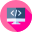 **TODO!**

Complete this function by added missing info and ROC, AUC scores

In [39]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, plot_roc_curve
import matplotlib.pyplot as plt
import seaborn as sn

def show_eval(y_true, y_pred, lb_trained, clf):
  ''' 
  Show eval metrics.  Takes binarized y true and pred along with trained binarizer for label names
  '''
  y_true_names = lb_trained.inverse_transform(y_true)
  y_pred_names = lb_trained.inverse_transform(y_pred)
  print( classification_report(y_true_names, y_pred_names) )
  cm = confusion_matrix(y_true_names, y_pred_names) 
  labels = ['negative', 'neutral', 'positive']
  df_cm = pd.DataFrame(cm, index=labels, columns=labels)
  
  sn.set(font_scale=1.2)
  sn.heatmap(df_cm, annot=True, annot_kws={"size": 18}, cmap='coolwarm', linewidth=0.5, fmt="")
  plt.show()

  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  for i, label in enumerate(labels):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    print(label, roc_auc[i])

  for i, label in enumerate(labels):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic for '+label)
    plt.legend(loc="lower right")
    plt.show()

              precision    recall  f1-score   support

    negative       0.81      0.91      0.86      1844
     neutral       0.60      0.51      0.55       606
    positive       0.76      0.56      0.64       478

    accuracy                           0.77      2928
   macro avg       0.72      0.66      0.68      2928
weighted avg       0.76      0.77      0.76      2928



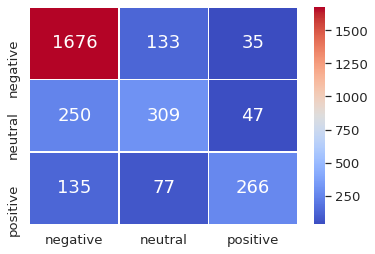

negative 0.8200216519518774
neutral 0.7140652049701094
positive 0.7944206301767569


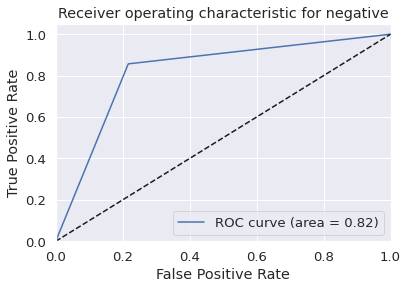

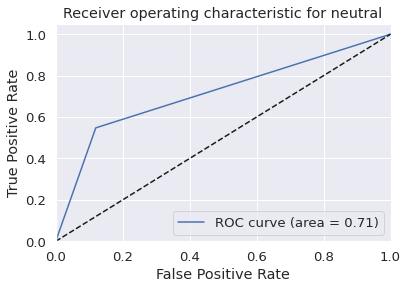

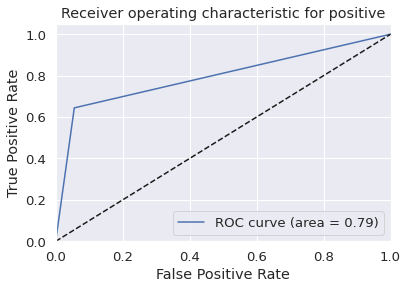

In [40]:
show_eval(dev_data_label, y_pred_vs_clf, lb_encoder, one_vs_clf)

## Using Random Forest (Multiple decision trees)

Now apply the same task and logic but using **Random Forest** instead.

Please note that you do not need the **OneVSRestClassifier** class for this one.

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

Tips: 
- for faster computation reduce the number of trees in the forest (i.e. estimators)
```python
n_estimators=300
```
- use all available cores from the CPU:
```python
n_jobs=-1
```


## 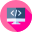 **TODO!**

Train the [Random Forest Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) and then use the trained classifier to predict labels on dev set.

Finally use `show_eval()` function to display evaluation info.

In [41]:
from sklearn.ensemble import RandomForestClassifier
# @TODO train RF classifier

In [42]:
# @TODO use trained classifier and predict on dev
# @TODO use eval function to display eval metrics

In [43]:
rnd_clf = RandomForestClassifier(n_jobs=-1)
rnd_clf.fit(train_data.toarray(), label_train)
y_rnd_pred = rnd_clf.predict(dev_set)

              precision    recall  f1-score   support

    negative       0.72      0.98      0.83      1844
     neutral       0.69      0.27      0.39       606
    positive       0.88      0.33      0.48       478

    accuracy                           0.72      2928
   macro avg       0.76      0.52      0.56      2928
weighted avg       0.74      0.72      0.68      2928



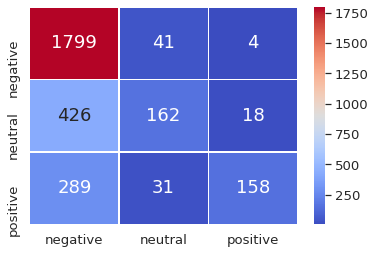

negative 0.7696928704644963
neutral 0.6181594903676414
positive 0.6607821706088294


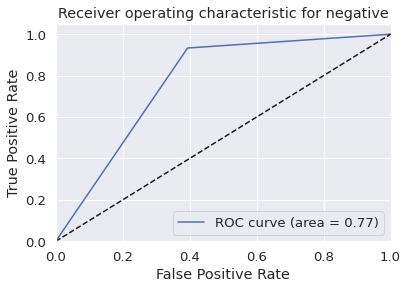

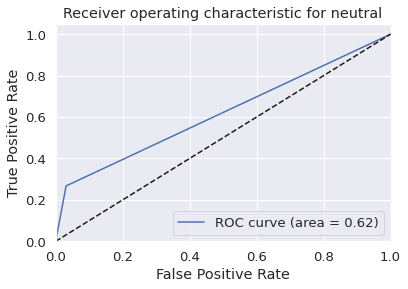

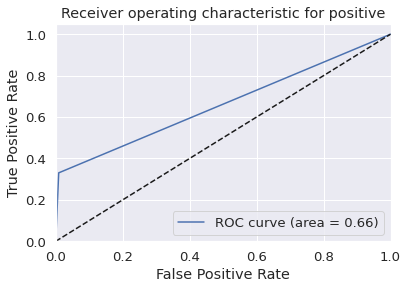

In [44]:
show_eval(dev_data_label, y_rnd_pred, lb_encoder, rnd_clf)

Shapes are different !!
y_pred_rnd  [[1 0 0]
 [1 0 0]
 [1 0 0]
 ...
 [0 1 0]
 [1 0 0]
 [1 0 0]]  y_rnd_score  [[[0.44       0.56      ]
  [0.19       0.81      ]
  [0.15       0.85      ]
  ...
  [0.75       0.25      ]
  [0.32       0.68      ]
  [0.22       0.78      ]]

 [[0.77333333 0.22666667]
  [0.85       0.15      ]
  [0.9        0.1       ]
  ...
  [0.29       0.71      ]
  [0.82       0.18      ]
  [0.82       0.18      ]]

 [[0.78666667 0.21333333]
  [0.96       0.04      ]
  [0.95       0.05      ]
  ...
  [0.96       0.04      ]
  [0.86       0.14      ]
  [0.96       0.04      ]]]
y_score new shape  (2928, 3)
              precision    recall  f1-score   support

    negative       0.76      0.96      0.85      1844
     neutral       0.66      0.37      0.47       606
    positive       0.82      0.47      0.60       478

    accuracy                           0.76      2928
   macro avg       0.75      0.60      0.64      2928
weighted avg       0.75      0.76      0.73

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning:

arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.



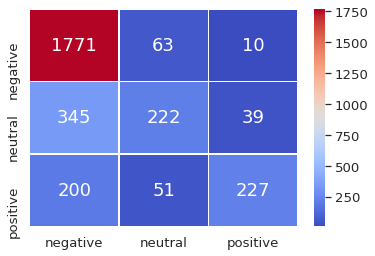

negative 0.8828648413924487
neutral 0.8256194159467627
positive 0.9084792075826145


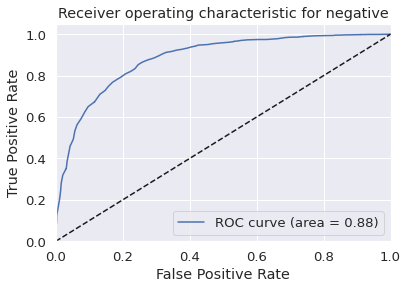

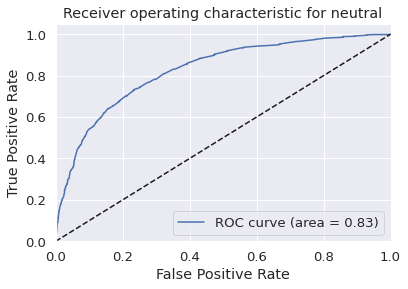

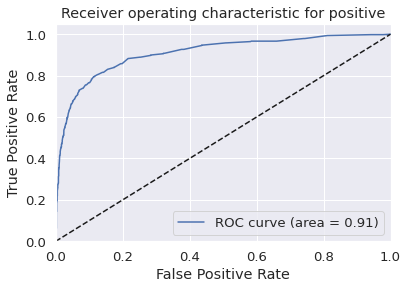

In [45]:
REPEATING_IT  = 50
y_rnd_score = rnd_clf.predict_proba(dev_set)
y_rnd_score = np.array(y_rnd_score)
print("="*REPEATING_IT)
print("Shapes are different !!")
print("y_pred_rnd ", y_rnd_pred, " y_rnd_score ", y_rnd_score)
print("="*REPEATING_IT)

classes_proba = (class_bin_prob[:, 1] for class_bin_prob in y_rnd_score)
y_rnd_score = np.column_stack(classes_proba)
print("y_score new shape ", y_rnd_score.shape)

#show_eval(dev_data_label, y_rnd_pred, lb_encoder, rnd_vs_clf)
show_eval(dev_data_label, y_rnd_score, lb_encoder, rnd_clf)

## Using pre-trained word embeddings

Apply the same task but using the embeddings vectors trained in the previous session and available in gensim model variable **pol_vw**. Use these embeddings as an input for **LinearSVC** and **Random Forest** classifiers.

Beware of the out of vocabulary words, find a way to handle them.

Remember we need a two dimensional array as a result:
(8784, 100)

In [46]:
# Create a function to transform the corpus into an embedding one
def tokens2vectors(tokenCorpus, model=None):
  ''' transforms our X into a list of list of vec (2D array) '''
  assert model != None, "Please the pretrained model is not defined"
  new_sample = list()
  for sample in tokenCorpus:
    tweetVecs = list()
    for token in sample.split(' '):
      try: tweetVecs.append(model.get_vector(token)  )
      except: tweetVecs.append( np.zeros(100) ) 
    new_sample.append(np.mean(tweetVecs, axis=0))
  return np.array(new_sample)

In [47]:
X_train_vec = tokens2vectors(x_train, model=pol_wv)
print(X_train_vec.shape, train_data.shape)

# print(type(X_train_cv.toarray()), type(X_train_vec))
X_dev_vec = tokens2vectors(dev_data, model=pol_wv)
X_test_vec = tokens2vectors(test_data, model=pol_wv)

(8784, 100) (8784, 10521)


## 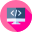 **TODO!**

Train an SVM on train set (embeddings), predict labels on dev set, and evaluate it using `show_eval()`

In [48]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn import svm

svc = svm.SVC(kernel='linear', probability=True)
clf_svm = OneVsRestClassifier(svc)
clf_svm = clf_svm.fit(X_train_vec, label_train)

y_score_svm = clf_svm.decision_function(X_dev_vec)

              precision    recall  f1-score   support

    negative       0.69      0.98      0.81      1844
     neutral       0.68      0.03      0.05       606
    positive       0.73      0.42      0.54       478

    accuracy                           0.70      2928
   macro avg       0.70      0.48      0.47      2928
weighted avg       0.70      0.70      0.61      2928



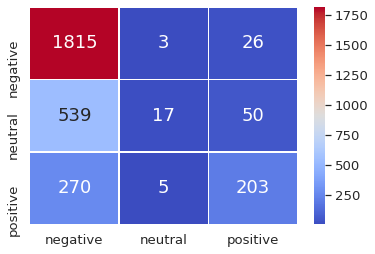

negative 0.7893449684225693
neutral 0.7449660017681354
positive 0.8726248825890188


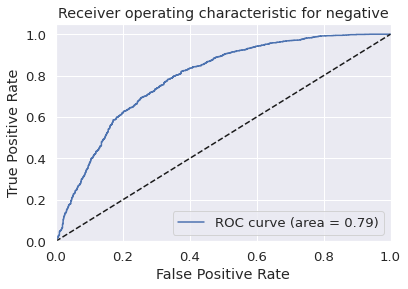

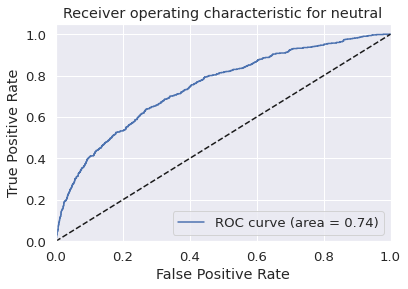

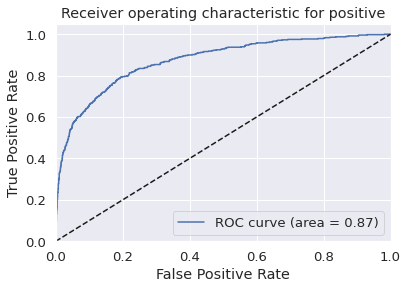

In [49]:
show_eval(dev_data_label, y_score_svm, lb_encoder, clf_svm)

## 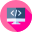 **TODO!**

Do the same using RandomForest for comparison: train on train set (embeddings), predict on dev set, eval using `show_eval()`

In [50]:
from sklearn.ensemble import RandomForestClassifier
# @TODO train RF classifier on train set (embeddings version)

In [53]:
rnd_clf = RandomForestClassifier()
rnd_clf = rnd_clf.fit(X_train_vec, label_train)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning:

arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.



              precision    recall  f1-score   support

    negative       0.73      0.94      0.82      1844
     neutral       0.57      0.28      0.38       606
    positive       0.74      0.42      0.54       478

    accuracy                           0.72      2928
   macro avg       0.68      0.55      0.58      2928
weighted avg       0.70      0.72      0.68      2928



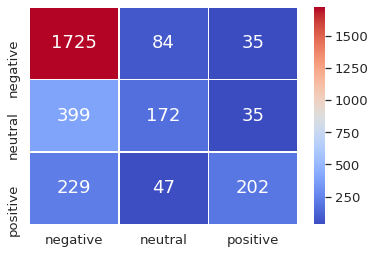

negative 0.7915444325267547
neutral 0.7249142226884188
positive 0.8516646742378958


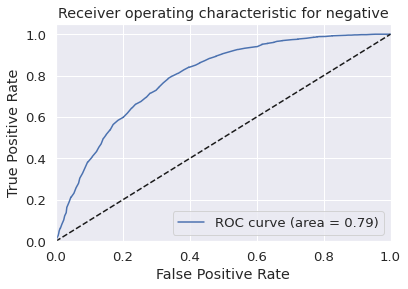

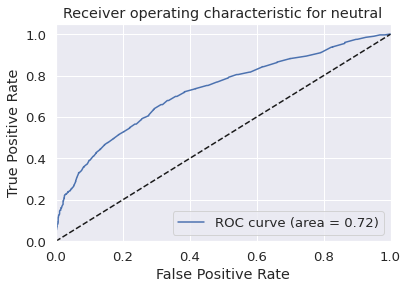

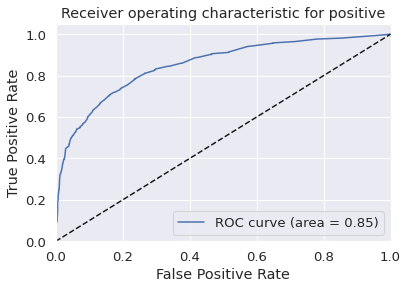

In [57]:
y_score_rnd = rnd_clf.predict_proba(X_dev_vec)
y_score_rnd = np.array(y_score_rnd) 
classes_proba = (class_binary_proba[:,1] for class_binary_proba in y_score_rnd)
y_score_rnd = np.column_stack(classes_proba)

show_eval(dev_data_label, y_score_rnd, lb_encoder, rnd_clf)

In [ ]:
show_eval(dev_data_label, y_score_rndd, lb_encoder, rnd_clf)

Here you go. You did apply some very basic supervised learning on tweets using extracted generic textual features (bag of words with counts) and two types of classifiers (decision tree based and support vector machine based).

Congratulations and see you soon for the next session.
